In [ ]:
# Imports
import torch
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch.nn as nn
import copy
from IPython.display import clear_output 
!pip install tensorly
import tensorly as tl
import tensorly.decomposition as td
clear_output()
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# !! fixed random seed! 

# Download training dataset
dataset = MNIST(root='data/', download=True)
vali_dataset = MNIST(root='data/', train=False)
print('data set length:',len(dataset),'vali data length:',len(vali_dataset))

# Transform to tensors
train_dataset = MNIST(root='data/', 
                train=True,
                transform=transforms.ToTensor())

# training data and validation data.
train_ds = train_dataset
val_ds = MNIST(root='data/', 
                train=False,
                transform=transforms.ToTensor())

data set length: 60000 vali data length: 10000


In [ ]:
#pip install git+https://github.com/KinglittleQ/torch-batch-svd.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/KinglittleQ/torch-batch-svd.git to /tmp/pip-req-build-gk9zi8qh
  Running command git clone -q https://github.com/KinglittleQ/torch-batch-svd.git /tmp/pip-req-build-gk9zi8qh
  Created wheel for torch-batch-svd: filename=torch_batch_svd-1.1.0+49b4aed-cp37-cp37m-linux_x86_64.whl size=1653210 sha256=0f5c29991f133ab97d457ac804647422c75276ffd1b1fc7f44fe5611062a237e
  Stored in directory: /tmp/pip-ephem-wheel-cache-glcab_nv/wheels/dc/1d/4b/841499aa10a68cf62c135258b7e0e07ac940ce1e468332d863
Successfully built torch-batch-svd


In [ ]:
from sklearn.utils.extmath import randomized_svd
import numpy
a=numpy.ones((2,3))
s,v,d = randomized_svd(a,2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:376: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  FutureWarning,


In [ ]:
import torch
a=torch.ones((2,3))
_,_,c = torch.svd(a)
m,n=c.shape


3

In [ ]:
# Specify device
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    else:
      return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
# Build CNN models, 3 convolution layers.

# Define evaluation function
def accuracy(outputs, labels_s):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels_s).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels_s = batch 
        labels=F.one_hot(labels_s.to(torch.int64), 10).float()    # !! number of labels used here!!              
        out = self(images)                  # Generate predictions
        loss = F.mse_loss(out, labels) # Calculate loss, mean suqare loss
        return loss
    
    def validation_step(self, batch):
        images, labels_s = batch 
        labels=F.one_hot(labels_s.to(torch.int64), 10).float()    # !! number of labels used here!!              
        out = self(images)                  # Generate predictions
        loss = F.mse_loss(out, labels) # Calculate loss, mean suqare loss
        acc = accuracy(out, labels_s)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}, features, out

    def vali_grad(self, batch, device):
        images, labels_s = batch 
        images, labels_s = images.to(device), labels_s.to(device)
        out = self(images)                  
        grad_val = torch.autograd.grad(out, images, create_graph=True)
        return grad_val


    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

# Define network
def conv_block(input_channels, out_channels, kernel_size, padding, batch_norm = True, pool=True):
    layers = [nn.Conv2d(input_channels, out_channels, kernel_size, 1, padding)]
    if batch_norm: 
      layers.append(nn.BatchNorm2d(out_channels))
    layers.append(nn.ReLU(inplace=True))
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

def in_out_channel(in_channel=128, layer=1, rate=1/2, mode='exp'):
  if mode == 'exp':
    out_channel = int(in_channel*rate**layer)
  if mode == 'linear':
    out_channel = int(in_channel - layer*rate)
  return out_channel
def classifier_in_dim(out):
  return len(torch.flatten(out, start_dim=1))

class CNN3(ImageClassificationBase):
    def __init__(self, num_conv_layers = 3, input_channels=1, out_channels_base=16, rate=2, mode = 'exp',
                  num_classes=10, batch_norm = True, pool = True):
        super().__init__()
        '''
        self.conv_layers = {}         
        self.__dict__['conv1'] = conv_block(
            input_channels,out_channels_base, 
            kernel_size=3, padding=1, batch_norm=batch_norm, pool=pool)
        for cov_layer in range(num_conv_layers-1):
          name_layer = 'conv'+str(cov_layer+2)
          self.__dict__[name_layer] = conv_block(
            in_out_channel(out_channels_base, layer=cov_layer, rate=rate, mode=mode), 
            in_out_channel(out_channels_base, layer=cov_layer+1, rate=rate, mode=mode), 
            kernel_size=3, padding=1, batch_norm=batch_norm, pool=pool)
        '''
        self.conv1 = conv_block(
            input_channels, out_channels_base, 
            kernel_size=3, padding=1, batch_norm=batch_norm, pool=pool)
        self.conv2 = conv_block(
            out_channels_base, 
            in_out_channel(out_channels_base, layer=1, rate=rate, mode=mode), 
            kernel_size=3, padding=1, batch_norm=batch_norm, pool=pool)
        self.conv3 = conv_block(
            in_out_channel(out_channels_base, layer=1, rate=rate, mode=mode), 
            in_out_channel(out_channels_base, layer=2, rate=rate, mode=mode), 
            kernel_size=3, padding=1, batch_norm=batch_norm, pool=pool)
        '''
        self.conv4 = conv_block(
            in_out_channel(out_channels_base, layer=2, rate=rate, mode=mode), 
            in_out_channel(out_channels_base, layer=3, rate=rate, mode=mode), 
            kernel_size=3, padding=1, batch_norm=batch_norm, pool=pool)
        self.conv5 = conv_block(
            in_out_channel(out_channels_base, layer=3, rate=rate, mode=mode), 
            in_out_channel(out_channels_base, layer=4, rate=rate, mode=mode), 
            kernel_size=3, padding=1, batch_norm=batch_norm, pool=pool)
        '''
        self.lin_batch = nn.BatchNorm1d(288)
        self.classifier = nn.Linear(288, 10, bias=False)  # No bias. No softmax

    def forward(self, out):
        '''
        num_conv_layers = 3
        for cov_layer in range(num_conv_layers):
          name_layer = 'conv'+str(cov_layer+1)
          out = getattr(self, name_layer)(out)
        '''
        out = self.conv1(out)
        out = self.conv2(out)
        out = self.conv3(out)
        #out = self.conv4(out)
        #out = self.conv5(out)
        
        out = torch.flatten(out, start_dim=1)
        out = self.lin_batch(out)
        out = self.classifier(out)
        return out     

In [ ]:
# Define a hook
features = {}
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

In [ ]:
from torch.cuda import current_device
# Train the model
@torch.no_grad() #features
def evaluate(model, val_loader, compute_phi):
    model.eval()
    outputs = []
    FEATS = []
    num_batch = len(val_loader)
    f_out = torch.empty((0, 10))
    for batch in val_loader:
      output, features, out = model.validation_step(batch)
        # placeholder for batch features
      outputs.append(output)
      f_out = torch.vstack((f_out, out.cpu()))
      FEATS.append(features['phi'].cpu().numpy())
    if compute_phi:
      phi = torch.flatten(torch.from_numpy(FEATS[0]), 1)
      for i in range(num_batch-1):
        phi = torch.vstack((phi, torch.flatten(torch.from_numpy(FEATS[i+1]), 1)))
    else:
      phi = torch.empty((1,1))
    return model.validation_epoch_end(outputs), phi, f_out

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, decrease_lr, model, train_loader, val_loader, first_kernel_base, rate, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    Iter = len(train_loader)
    history = []
    epoch_state_dict = {}
    Phi = {}
    F_out = {}
    # Set up one-cycle learning rate scheduler
#    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
#                                               steps_per_epoch=len(train_loader))
    '''
    checkpoint = {'batch_size': batch_size,
              'fist_kernel_base': first_kernel_base,
              'rate': rate, 
              'state_dict': model.state_dict()}
    epoch_state_dict[0] = copy.deepcopy(checkpoint)
    '''
    lr = max_lr
    train_losses = []
    lrs = []
    valtime = []
    iter = 0
    val_iter = 0
    train_batches = len(train_loader)
    model.eval()
    with torch.no_grad():
      result, phi, f_out = evaluate(model, val_loader, compute_phi=False)
      F_out[0] = f_out
      valtime.append(0)
    for epoch in range(epochs):
        # update
        if decrease_lr:
          lr = max_lr - (max_lr-0.01)/int(epochs/10)*int(epoch/10)
        # Set up cutom optimizer with weight decay
        optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)
        # Training Phase 
        for batch in train_loader:
          model.train()
          loss = model.training_step(batch)
          train_losses.append(loss)
          loss.backward()
          
          # Gradient clipping
          if grad_clip: 
              nn.utils.clip_grad_value_(model.parameters(), grad_clip)
          
          optimizer.step()
          optimizer.zero_grad()
          
          # Record & update learning rate
          lrs.append(get_lr(optimizer))
          #sched.step()

          # Validation phase
          if iter%20 == 0 and iter<2000:
            model.eval()
            with torch.no_grad():
              result, phi, f_out = evaluate(model, val_loader, compute_phi=False)
              F_out[iter+1] = f_out
              valtime.append(iter+1)
              # model.validation_epoch_end(iter, result)
          iter += 1

#        if result['val_acc']>0.99:
#          print('Mission completed! Acc>0.99')
#          return history, epoch_state_dict, phi, F_out
        checkpoint = {'batch_size': batch_size,
              'fist_kernel_base': first_kernel_base,
              'rate': rate, 
              'state_dict': model.state_dict()}
        epoch_state_dict[epoch+1] = copy.deepcopy(checkpoint)
        #print(torch.cuda.memory_summary(device=current_device, abbreviated=False))
    model.eval()
    with torch.no_grad():
      result, phi, fifout = evaluate(model, val_loader, compute_phi=True)
          #model.validation_epoch_end(iter, result)
    history.append(result)

    # computing gradient to parameters.

    return train_losses, phi, F_out, valtime, history[-1], epoch_state_dict, fifout

In [ ]:
# experiment setting: width of net
out_channels_base=128
rate=1/2
mode = 'exp'

# experiment setting: depth of net
num_conv_layers = 3
# Split training data into batches
batch_size = 32

batch_norm = True
epochs = 10 #9
max_lr = 0.03 #0.05
decrease_lr = False
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.SGD

#when layer==1, initial acc=0.18, fist train 0.95
#when layer==2, initial acc=0.06, fist train 0.96
#when layer==3, initial acc=0.04, fist train 0.94
#when layer==4, initial acc=0.1, fist train 0.86
train_loader = DataLoader(train_ds, batch_size, shuffle=True) 
val_loader = DataLoader(val_ds, 4*batch_size)
device = get_default_device()
print(device)   
train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(val_loader, device)

model = to_device(CNN3(num_conv_layers = num_conv_layers,
    input_channels=1, out_channels_base=out_channels_base, 
    rate=rate, mode = mode,
    num_classes=10, batch_norm = batch_norm, pool = True), device)
# Register a hook for the last layer
model.lin_batch.register_forward_hook(get_features('phi'))

cuda


In [ ]:
import time
model
trainloss, Phi, F_out, valtime, history, epoch_state_dict, ffout = fit_one_cycle(epochs, max_lr, decrease_lr,
                             model, train_dl, valid_dl, 
                             first_kernel_base=out_channels_base, rate=rate,
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

trainloss = [x.detach().cpu().numpy() for x in trainloss]
torch.save(trainloss, 'trainloss')
torch.save(F_out, 'F_out')
torch.save(valtime, 'valtime')
torch.save(epoch_state_dict, 'epoch_model')
torch.save(Phi, 'Phi')
torch.save(ffout, 'ffout')

'''
F_out[0] = f_out
_, S, _ = torch.svd(Phi)
torch.save(S, 'out128_linear-rate10_layer3')
print(len(S))
# experiment setting:
#batch_size = 32
#out_channels_base=128
#rate=2/3
#mode = 'exp'
#batch_norm = False #true
history += val_history 
'''

"\nF_out[0] = f_out\n_, S, _ = torch.svd(Phi)\ntorch.save(S, 'out128_linear-rate10_layer3')\nprint(len(S))\n# experiment setting:\n#batch_size = 32\n#out_channels_base=128\n#rate=2/3\n#mode = 'exp'\n#batch_norm = False #true\nhistory += val_history \n"

In [ ]:
epoch_model = torch.load('epoch_model', map_location=device)
model.to(device)
model.load_state_dict(epoch_model[2]['state_dict'])

<All keys matched successfully>

In [ ]:
model

CNN3(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lin_batch): BatchNorm1d(288, eps=1e-05, momentum=0.1, affine=True, track_running

In [ ]:
model.train()
for batch in valid_dl:
  imag, ind = batch
  out = model(imag)


AttributeError: ignored

In [ ]:
model.classifier.

Sequential(
  (0): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=0, out_features=10, bias=False)
)

In [ ]:
for batch in valid_dl:
  imag, ind = batch
  out = model(imag)

In [ ]:
a=torch.zeros((10,100))
b=torch.rand(1000)
for i in range(10):
  a[i,:] = b[100*i:100*(i+1)].reshape(-1)
a

In [ ]:
torch.save(ffout, 'ffout')


In [ ]:
pip install git+http://github.com/tfjgeorge/nngeometry.git

In [ ]:
pip install git+http://github.com/tfjgeorge/nngeometry.git
from nngeometry.object.fspace import FMatDense
from nngeometry.object.vector import FVector
from nngeometry.object import PMatImplicit
from nngeometry.generator import Jacobian
from nngeometry.layercollection import LayerCollection


In [ ]:
epoch_model = torch.load('epoch_model')
model.load_state_dict(epoch_model[2]['state_dict'])
model

CNN3(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): BatchNorm1d(288, eps=1e-05, momentum=0.1, affi

In [ ]:
lc = LayerCollection.from_model(model)
Jac = Jacobian(model, n_output=10, centering=True, layer_collection=lc)

In [ ]:
del grad
del Grad
torch.cuda.empty_cache()
ib = 0
num = 0
i=0
model.eval()
for batch in valid_dl:
  if num==1:
    break
  if ib == 0:
    grad = (Jac.get_jacobian(batch)).detach().cpu()
    [D,L,W] = grad.shape
    Grad = torch.zeros((100000,W ))
    for i in range(10):
        Grad[10000*i:10000*i+L, :] = grad[i, :, :]
    del grad
    torch.cuda.empty_cache()
    ib = 1
    num += 1
  else:
    grad = torch.cat([grad, Jac.get_jacobian(batch).detach().cpu()], dim = 1)
    [_,l,_] = grad.shape
    for i in range(10):
        Grad[ 10000*i+num*L: 10000*i+num*L+l, :] = grad[i, :, :]
    del grad
    torch.cuda.empty_cache()
    num += 1
torch.save(Grad, 'Grad')

In [ ]:
Grad.shape

torch.Size([10000, 97440])

In [ ]:
i=0
num = 1
for batch in valid_dl:
  if i== 10:
    torch.save(grad, 'grad_{}'.format(num))
    num += 1
    i =0
  if i==0:
    grad = (Jac.get_jacobian(batch)).detach().cpu()
  else:
    grad = torch.cat([grad, Jac.get_jacobian(batch).detach().cpu()], dim = 1)
  i+=1  
torch.save(grad, 'grad_{}'.format(num))

NameError: ignored

In [ ]:
i

6

In [ ]:
a = grad[1,:,:]
b= grad[:,:,1]

In [ ]:
model

CNN3(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): LazyBatchNorm1d(0, eps=1e-05, momentum=0.1, af

In [ ]:
epoch_state_dict = torch.load('epoch_model')
epoch_state_dict[2]['state_dict'].keys()

odict_keys(['conv1.0.weight', 'conv1.0.bias', 'conv1.1.weight', 'conv1.1.bias', 'conv1.1.running_mean', 'conv1.1.running_var', 'conv1.1.num_batches_tracked', 'conv2.0.weight', 'conv2.0.bias', 'conv2.1.weight', 'conv2.1.bias', 'conv2.1.running_mean', 'conv2.1.running_var', 'conv2.1.num_batches_tracked', 'conv3.0.weight', 'conv3.0.bias', 'conv3.1.weight', 'conv3.1.bias', 'conv3.1.running_mean', 'conv3.1.running_var', 'conv3.1.num_batches_tracked', 'classifier.0.weight', 'classifier.0.bias', 'classifier.0.running_mean', 'classifier.0.running_var', 'classifier.0.num_batches_tracked', 'classifier.1.weight'])

In [ ]:
from nngeometry.object.fspace import FMatDense
from nngeometry.object.vector import FVector
from nngeometry.object import PMatImplicit
from nngeometry.generator import Jacobian
from nngeometry.layercollection import LayerCollection
epoch_state_dict = torch.load('epoch_model')
model.load_state_dict(state_dict=epoch_state_dict[2]['state_dict'])
lc = LayerCollection.from_model(model)
Jac = Jacobian(model, n_output=10, centering=True, layer_collection=lc)

ib = 0
num = 0

for batch in valid_dl:
  if ib>0:
    break
  else:
    if ib == 0:
      grad = (Jac.get_jacobian(batch)).detach().cpu()
      [D,L,W] = grad.shape
      Grad = torch.zeros((D*10000,W ))
      for i in range(10):
          Grad[ 10000*i: 10000*i+L, :] = grad[i, :, :]
      del grad
      torch.cuda.empty_cache()
      ib = 1
      num += 1
    else:
      grad = (Jac.get_jacobian(batch)).detach().cpu()
      [_,l,_] = grad.shape
      for i in range(10):
          Grad[ 10000*i+num*L: 10000*i+num*L+l, :] = grad[i, :, :]
      del grad
      torch.cuda.empty_cache()
      num += 1
torch.save(Grad, 'Grad')

_, S, V = torch.svd(Grad)
torch.save(S, 'S')
torch.save(V, 'V')

tan_ker = Grad.mm(V)
torch.save(tan_ker, 'full_tan_ker')
del Grad
del V
u_10 = tan_ker[:, 10]
torch.save(u_10, '10_tan_ker')
del tan_ker
# method 2: after kernel:
Coe = {}
for i in range(5):
  u_i = u_10[:,i]
  u = torch.zeros((10, 10000))
  for k in range(10):
    u[k,:] = u_i[10000*k: 10000*(k+1)].reshape(-1)
  coe = []
  Iter = len(F_out.keys())
  for iter in range(Iter):
    coe.append(abs(torch.trace(F_out[valtime[iter]].mm(u))))
  Coe[i+1] = coe
  i_1=i+1
  plt.plot(valtime[0:Iter], coe, linewidth=2, label=r'$\beta_{%s}$'%i_1)
  plt.locator_params(axis='x', nbins=8)
  plt.legend(prop={'size': 10})
  axes = plt.gca()
  #plt.xlim(0, 1100)
plt.xlabel("Iteration $T$", color='k')
plt.legend(loc='lower right', prop={'size': 18})
axes = plt.gca()
axes.xaxis.label.set_size(18)
axes.yaxis.label.set_size(18)
plt.xticks(color='k', fontsize=14)
plt.yticks(color='k', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('tangent kernel')


Exception: ignored

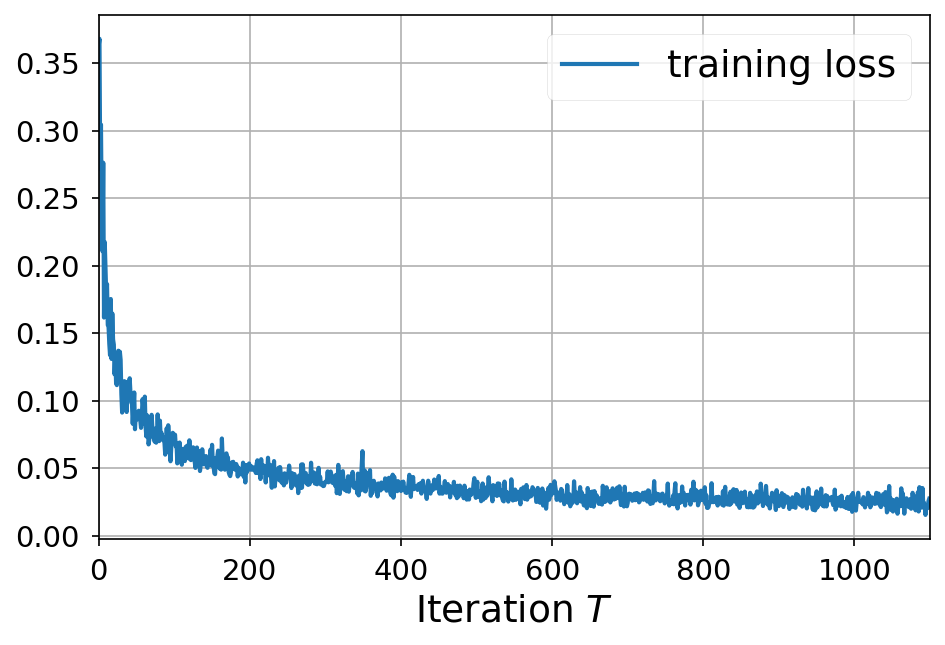

In [ ]:
# plotting style
plt.style.use('seaborn-paper')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 150
#trainloss = torch.load('trainloss')
plt.plot(trainloss[0:1100], linewidth=2, label='training loss')
plt.locator_params(axis='x', nbins=8)
plt.xlim(0, 1100)
plt.xlabel("Iteration $T$", color='k')
plt.legend(loc='upper right', prop={'size': 18})
plt.legend(prop={'size': 18})
axes = plt.gca()
axes.xaxis.label.set_size(18)
axes.yaxis.label.set_size(18)
plt.xticks(color='k', fontsize=14)
plt.yticks(color='k', fontsize=14)
plt.grid(True)
plt.tight_layout()
#plt.savefig('mnist-loss')

In [ ]:
'''
torch.save(trainloss, 'trainloss')
torch.save(F_out, 'F_out')
torch.save(valtime, 'valtime')
torch.save(epoch_state_dict[2]['state_dict']['classifier.1.weight'], 'beta')
torch.save(Phi, 'Phi')
'''
#U, S, V = torch.svd(Phi)
beta = epoch_state_dict[2]['state_dict']['classifier.1.weight'].detach().cpu()
U, S, Vh = torch.linalg.svd(Phi)
V=Vh.t()
beta_star = torch.matmul(beta, V)
Coe = {}

TypeError: ignored

In [ ]:
epoch_state_dict[1]['state_dict'].keys()

odict_keys(['conv1.0.weight', 'conv1.0.bias', 'conv1.1.weight', 'conv1.1.bias', 'conv1.1.running_mean', 'conv1.1.running_var', 'conv1.1.num_batches_tracked', 'conv2.0.weight', 'conv2.0.bias', 'conv2.1.weight', 'conv2.1.bias', 'conv2.1.running_mean', 'conv2.1.running_var', 'conv2.1.num_batches_tracked', 'conv3.0.weight', 'conv3.0.bias', 'conv3.1.weight', 'conv3.1.bias', 'conv3.1.running_mean', 'conv3.1.running_var', 'conv3.1.num_batches_tracked', 'lin_batch.weight', 'lin_batch.bias', 'lin_batch.running_mean', 'lin_batch.running_var', 'lin_batch.num_batches_tracked', 'classifier.weight'])

In [ ]:
F_out = torch.load('F_out')
Phi = torch.load('Phi')
epoch_model = torch.load('epoch_model', map_location=device)
valtime = torch.load('valtime')

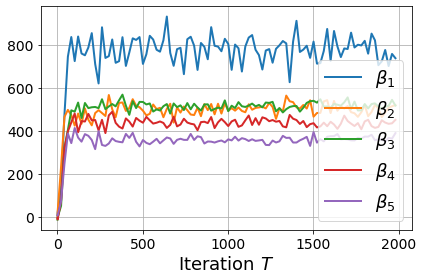

In [ ]:
# method 1: conjugate kernel:
beta = epoch_state_dict[10]['state_dict']['classifier.weight'].detach().cpu()
U, S, V = torch.svd(Phi)
beta_star = torch.matmul(beta, V)
Coe = {}
for i in range(5):
  u = torch.outer(beta_star[:,i], U[:,i])
  norm_u = torch.trace(u.t().mm(u))/10000
  u = u/norm_u
  coe = []
  Iter = len(F_out.keys())
  for iter in range(Iter):
    coe.append((torch.trace(F_out[valtime[iter]].mm(u)))/10000)
  Coe[i+1] = coe
  i_1=i+1
  plt.plot(valtime[0:Iter], coe, linewidth=2, label=r'$\beta_{%s}$'%i_1)
  plt.locator_params(axis='x', nbins=8)
  plt.legend(prop={'size': 10})
  axes = plt.gca()
  #plt.xlim(0, 1100)
plt.xlabel("Iteration $T$", color='k')
plt.legend(loc='lower right', prop={'size': 18})
axes = plt.gca()
axes.xaxis.label.set_size(18)
axes.yaxis.label.set_size(18)
plt.xticks(color='k', fontsize=14)
plt.yticks(color='k', fontsize=14)
plt.grid(True)
plt.tight_layout()
  

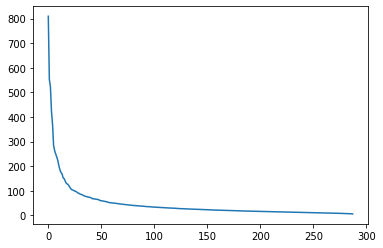

In [ ]:
plt.plot(S)

In [ ]:
i=0
u = torch.outer(beta_star[:,i], U[:,i])
norm_u = torch.trace(u.t().mm(u))/10000
u = u/norm_u
(torch.trace(ffout.mm(u)))/10000

tensor(915.6376)

In [ ]:
(torch.trace(ffout.mm(u)))/10000

tensor(270.3765)

In [ ]:
ffout.shape

torch.Size([10000, 10])

In [ ]:
torch.norm(ffout.t() - beta.mm(Phi.t()))/torch.norm(ffout)

tensor(0.5557)

In [ ]:
model

CNN3(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): BatchNorm1d(288, eps=1e-05, momentum=0.1, affi

In [ ]:
'''
torch.save(Phi, 'Phi')
torch.save(F_out, 'F_out')
torch.save(trainloss, 'trainloss')
torch.save(valtime, 'valtime')
'''

"\ntorch.save(Phi, 'Phi')\ntorch.save(F_out, 'F_out')\ntorch.save(trainloss, 'trainloss')\ntorch.save(valtime, 'valtime')\n"

In [ ]:
U, S, _ = torch.svd(Phi)
c=0
for i in range(len(S)):
  c=c+S[i]
  if c>0.9*sum(S):
    print('number is {}'.format(i+1))
    break

Base = torch.zeros((10000, 10, 2880))
for i in range(288):
  for j in range(10):
    Base[:, j, i*10+j]=U[:,i]

number is 167


In [ ]:
b = tl.tensor(Base)
import tensorly.decomposition as td
factors = td.parafac(b, rank=10)

test

tried: 

1.use the true 2880 tensor to decompose. a lot of err, but figure most good one for now. 

Note: use matlab tensor toolbox is much faster. I also record factors(rank=200)case. maybe this factor will plot better. maybe

2.all front slices to be rank 1 matrix. compute fast, shit as previous one.

3.front slice rotate the index of U in an iterate manner, not good.

In [ ]:
# tried rank=200--still not good
#Phi = torch.load('Phi (1)')
'''
valtime = torch.load('valtime')
F_out = torch.load('F_out')
fac10=si.loadmat('F1U1.mat')['F1_U1']
fac11=si.loadmat('F1U2.mat')['F1_U2']
fac0=si.loadmat('lambda.mat')['lambda']
'''

In [ ]:
#Phi = torch.load('Phi (1)')
#valtime = torch.load('valtime')
#F_out = torch.load('F_out')

In [ ]:
U, S, _ = torch.svd(Phi)
c=0
for i in range(len(S)):
  c=c+S[i]
  if c>0.9*sum(S):
    print('number is {}'.format(i+1))
    break
n=288
Base = torch.zeros((10000, 10, n))
for i in range(n):
  for j in range(10):
    Base[:, j, i]=U[:,(i+j)%288]
b = tl.tensor(Base)
factors = td.parafac(b, rank=10, n_iter_max=200, normalize_factors=True, tol=1e-10)
#factors = td.randomised_parafac(b, rank=10, n_samples=1000)
ind=np.argpartition(factors[0], -4)[-4:]


number is 165


In [ ]:

fac0=np.load('factors0.npy')
fac10=np.load('factors10.npy')
fac11=np.load('factors11.npy')


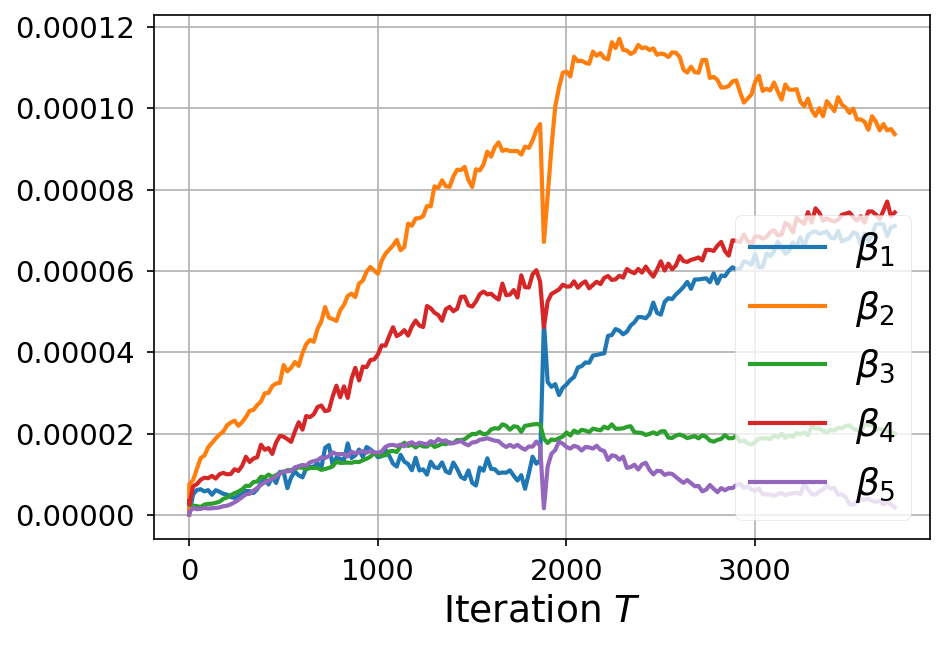

In [ ]:
plt.style.use('seaborn-paper')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 150
ind=np.argpartition(factors[0], -5)[-5:]
larg = ind
for i in range(len(larg)):
  u = torch.outer(torch.tensor(factors[1][0][:,larg[i]]), torch.tensor(factors[1][1][:,larg[i]]))
  coe = []
  Iter = len(F_out.keys())
  for iter in range(Iter):
    coe.append(abs(torch.sum(F_out[valtime[iter]]*u)/10000))
  i_1=i+1
  plt.plot(valtime[0:Iter], coe, linewidth=2, label=r'$\beta_{%s}$'%i_1)
  plt.locator_params(axis='x', nbins=8)
plt.legend(prop={'size': 10})
axes = plt.gca()
#plt.xlim(0, 1100)
plt.xlabel("Iteration $T$", color='k')
plt.legend(loc='lower right', prop={'size': 18})
axes = plt.gca()
axes.xaxis.label.set_size(18)
axes.yaxis.label.set_size(18)
plt.xticks(color='k', fontsize=14)
plt.yticks(color='k', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('mnist beta')

<function torch.clear_autocast_cache>

<function matplotlib.pyplot.show>

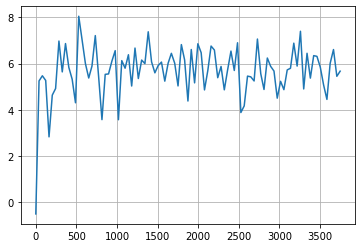

In [ ]:
# compute scaler function base for f_i.(matrix factorization) i = 3
i = 3
coe = []
Iter = len(valtime)
for iter in range(Iter):
  coe.append(torch.matmul(F_out[valtime[iter]][:, 8], U[:, 2]))
plt.plot(valtime, coe)
plt.grid()
plt.show



dict_keys([0, 40, 81, 122, 163, 203, 244, 285, 326, 366, 407, 448, 489, 529, 570, 611, 652, 692, 733, 774, 815, 855, 896, 937, 978, 1018, 1059, 1100, 1141, 1181, 1222, 1263, 1304, 1344, 1385, 1426, 1467, 1507, 1548, 1589, 1630, 1670, 1711, 1752, 1793, 1833, 1874, 1875, 1915, 1956, 1996, 2037, 2078, 2119, 2159, 2200, 2241, 2282, 2322, 2363, 2404, 2445, 2485, 2526, 2567, 2608, 2648, 2689, 2730, 2771, 2811, 2852, 2893, 2934, 2974, 3015, 3056, 3097, 3137, 3178, 3219, 3260, 3300, 3341, 3382, 3423, 3463, 3504, 3545, 3586, 3626, 3667, 3708, 3749, 3750])

<function matplotlib.pyplot.show>

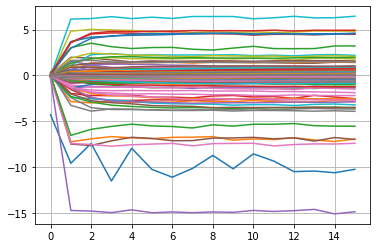

In [ ]:
i = 6
for j in range(len(U[0, :])):
  coe = []
  for epoch in range(epochs+1):
    coe.append(torch.matmul(F_out[epoch][:, i], U[:, j]))
  plt.plot(range(epochs+1), coe)
plt.grid()
plt.show # seems pretty good!

In [ ]:
# compute vector function base for f.(tensor factorization)



$\textbf{Experiment setting:}$
3 layers of (convolution + relu + maxpool), 1 linear layer without bias for prediction. No softmax, use l2 loss.
batch size = 32,
lr = 0.01, optimizer = SGD, data are scaled to $[0,1]$. Trained 20 epochs with final acc $95.07\%$. 

For parameters, I stored all parameters for every epoch during training and then reload parameters for each epoch to compute feature map $\phi$ for testing data and weight distance $W-W_{∞}$.

No handles with labels found to put in legend.


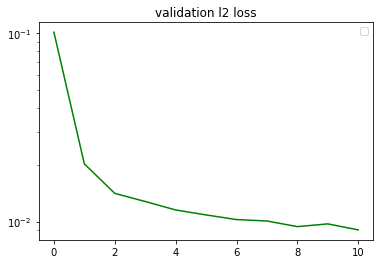

No handles with labels found to put in legend.


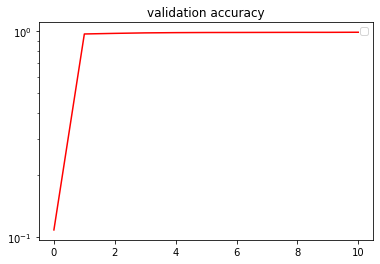

In [ ]:
# plot loss and accuracy
loss_epoch = []
acc_epoch = []
epochs = min(epochs, len(history)-1)
for epoch in range(epochs+1):
  loss_epoch.append(history[epoch]['val_loss']), acc_epoch.append(history[epoch]['val_acc'])

plt.plot(range(epochs+1), loss_epoch, 'g')
plt.yscale('log')
plt.title('validation l2 loss')
plt.legend()
plt.show()

plt.plot(range(epochs+1), acc_epoch, 'r')
plt.yscale('log')
plt.title('validation accuracy')
plt.legend()
plt.show()

Conjecture 1: Finding orthognal basis for function in each argument, and evaluate coefficient change:
$$
\phi_{i}(x)=\sum_{j}\alpha_{ij}K_{j}(x)
$$
where $K_{i}(x):R^{in}\rightarrow R$.

I use Gram–Schmidt method, starting from kernel 1, 2, 3, ...

$<\phi_{i}, \phi_{j}> = 1/N∑_{k\in Test}\phi_{i}(x_{k})\phi_{j}(x_{k})$

In [ ]:
# build orthognal function basis on emprical distribution
'''
root_K = Phi[epochs]
[test_size, num_neurans] = root_K.size()
K = torch.empty((test_size, num_neurans))
for neuran in range(num_neurans):
  base = root_K[:, neuran]
  for back_subtract in range(neuran):
    # subtract
    coeff = torch.sum(base * K[:, back_subtract])/test_size
    base = base - coeff*K[:, back_subtract]
  if torch.max(torch.abs(base)) == 0: 
    print('Not independent at {} neuran'.format(neuran))
  # normalize
    K[:, neuran] = torch.zeros((test_size))
  else:
    K[:, neuran] = test_size*base/(torch.sum(base**2))

U, S, Vh = torch.linalg.svd(Phi[epochs])
'''

"\nroot_K = Phi[epochs]\n[test_size, num_neurans] = root_K.size()\nK = torch.empty((test_size, num_neurans))\nfor neuran in range(num_neurans):\n  base = root_K[:, neuran]\n  for back_subtract in range(neuran):\n    # subtract\n    coeff = torch.sum(base * K[:, back_subtract])/test_size\n    base = base - coeff*K[:, back_subtract]\n  if torch.max(torch.abs(base)) == 0: \n    print('Not independent at {} neuran'.format(neuran))\n  # normalize\n    K[:, neuran] = torch.zeros((test_size))\n  else:\n    K[:, neuran] = test_size*base/(torch.sum(base**2))\n\nU, S, Vh = torch.linalg.svd(Phi[epochs])\n"

In [ ]:
len(Phi)

10

In [ ]:
K,s, t = torch.svd(Phi[9])
inv_K = torch.matmul(K, K.t())
d = []
for i in range(10):
    ort ,s, t= torch.svd(Phi[i])
    d.append(torch.norm(torch.matmul(ort, ort.t()) - inv_K, 'fro'))
d

KeyboardInterrupt: ignored

In [ ]:
# performing svd and pick the largest 95% eigenvalue.
# experiment set: 4 6 layers; 64, 256 width; extra dense linear layer, etc.
# use svd to build basis

# Save current state
name = '>0.99fast'
torch.save(epoch_state, name + '_state_dict.pth')                           
torch.save(Phi, name + '_Phi')
torch.save(K, name + '_K')
torch.save(U, name + '_U')
torch.save(S, name + '_S')


No handles with labels found to put in legend.


the 300th neuron


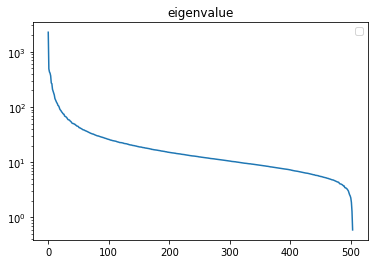

In [ ]:
total = torch.sum(S)
divid = .9*total
s = 0
for i in range(len(S)):
  if s<divid:
    s += S[i]
  else:
    print('the {}th neuron'.format(i))
    break

plt.plot(range(len(S)), S)
plt.yscale('log')
plt.title('eigenvalue')
plt.legend()
plt.show()

In [ ]:
# Use the result from another approach as infinity solution
# Don't run if you want to use the solution of current setting
'''
# load all_epoch_state[end]['state_dict'] to model
model.load_state_dict(all_epoch_state_acc[9]['state_dict'])
FEATS = []

  # placeholder for batch features
features = {}

  # loop through batches
for batch in test_dl:
  img, lbs = batch
      # forward pass [with feature extraction]
  preds = model(img)
      
      # add feats and preds to lists
  FEATS.append(features['phi'].cpu().numpy())
phi_acc = torch.flatten(torch.from_numpy(FEATS[0]), 1)
for i in range(num_batch-1):
  phi_acc = torch.vstack((phi_acc, torch.flatten(torch.from_numpy(FEATS[i+1]), 1)))
'''

"\n# load all_epoch_state[end]['state_dict'] to model\nmodel.load_state_dict(all_epoch_state_acc[9]['state_dict'])\nFEATS = []\n\n  # placeholder for batch features\nfeatures = {}\n\n  # loop through batches\nfor batch in test_dl:\n  img, lbs = batch\n      # forward pass [with feature extraction]\n  preds = model(img)\n      \n      # add feats and preds to lists\n  FEATS.append(features['phi'].cpu().numpy())\nphi_acc = torch.flatten(torch.from_numpy(FEATS[0]), 1)\nfor i in range(num_batch-1):\n  phi_acc = torch.vstack((phi_acc, torch.flatten(torch.from_numpy(FEATS[i+1]), 1)))\n"

For the 1,10,100-th kernel, we plot to see how the coefficient change:

ValueError: ignored

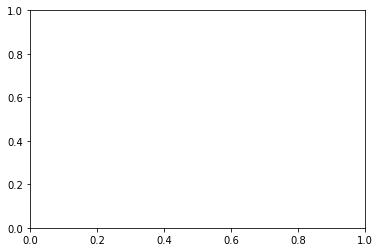

In [ ]:
#K = torch.load('K_20epochs')
#K = U
# making projections for the j-th function base, j=1,...,num_neuran. 
def coeff_base(Phi, K, j):
  epochs = len(Phi)
  [N, num_neuran] = Phi[0].size()
  base = K[:, j-1]
  coe = torch.empty((epochs, num_neuran))
  for epoch in range(epochs):
    coe[epoch, :] = torch.matmul(base.t(), Phi[epoch])/N
  return coe

j=2
coe = coeff_base(Phi, K, j)
# randomly choose some neurans and plot their coefficient change.
# NOT fix seed
import random
rand_pick = 20
sample = random.sample(range(len(coe[0, :])), rand_pick)
for i in range(rand_pick):
  plt.plot(range(epochs+1), coe[:, sample[i]])
plt.title('pick {} neuran for the {}th infity kernel'.format(rand_pick, j))
plt.show()

# the whole picture
for nueran in range(len(coe[0, :])):
  plt.plot(range(epochs+1), coe[:, nueran])

plt.title('change of coefficient of all neurans w.r.t. the {}th infity kernel'.format(j))

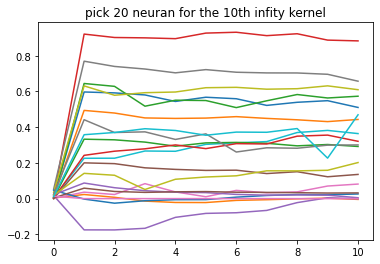

Text(0.5, 1.0, 'change of coefficient of all neurans w.r.t. the 10th infity kernel')

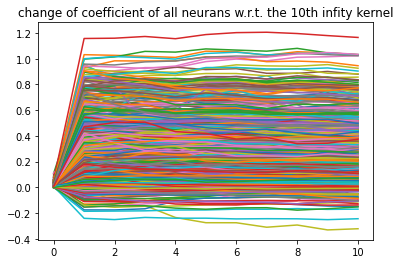

In [ ]:
j=10
coe = coeff_base(Phi, K, j)
rand_pick = 20
sample = random.sample(range(len(coe[0, :])), rand_pick)
for i in range(rand_pick):
  plt.plot(range(epochs+1), coe[:, sample[i]])
plt.title('pick {} neuran for the {}th infity kernel'.format(rand_pick, j))
plt.show()

for nueran in range(len(coe[0, :])):
  plt.plot(range(epochs+1), coe[:, nueran])

plt.title('change of coefficient of all neurans w.r.t. the {}th infity kernel'.format(j))

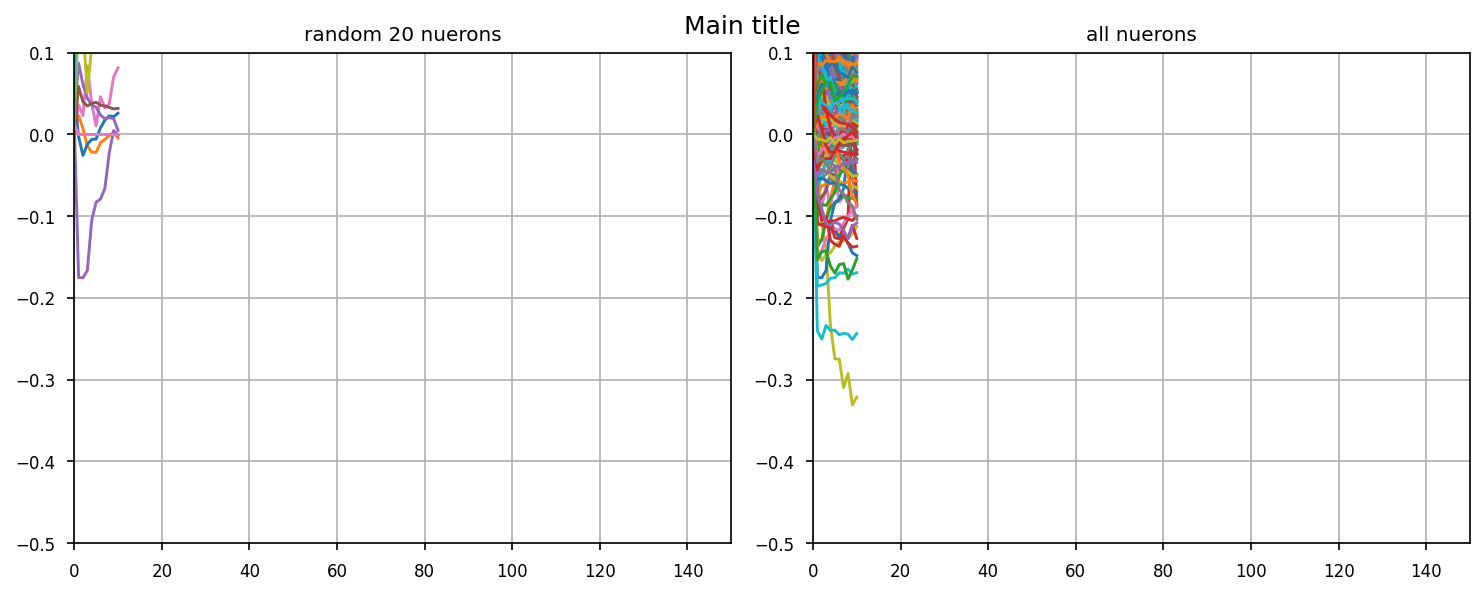

'\nplt.plot(training_accs, linewidth=2, label=\'train acc\')\nplt.plot(test_accs, linewidth=2, label=\'test acc\')\nplt.legend(loc=\'best\')\nplt.xlim(0, epoch + 1)\nplt.ylim(0, 1)\nplt.xlabel("epoch")\nplt.ylabel("accuracy")\nplt.legend(prop={\'size\': 18})\naxes = plt.gca()\naxes.xaxis.label.set_size(18)\naxes.yaxis.label.set_size(18)\nplt.xticks(color=\'k\', fontsize=14)\nplt.yticks(color=\'k\', fontsize=14)\nplt.grid(True)\nplt.tight_layout()\nplt.savefig(\'resnet_18\')\nplt.clf()\n'

In [ ]:
plt.style.use('seaborn-paper')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 150

fig = plt.figure(figsize=(10,4))
axes=fig.add_subplot(1,2,1)  
axes.set_xlim([0,150])
axes.set_ylim([-.5, .1])      
for i in range(rand_pick):
  plt.plot(range(epochs+1), coe[:, sample[i]])
plt.grid(True)
plt.tight_layout()

plt.title('random 20 nuerons'.format(rand_pick, j))

ax1 = fig.add_subplot(1,2,2)
ax1.set_xlim([0,150])
ax1.set_ylim([-.5, .1])
for nueran in range(len(coe[0, :])):
  plt.plot(range(epochs+1), coe[:, nueran])
plt.grid(True)
plt.tight_layout()
plt.title('all nuerons'.format(j))
plt.suptitle('Main title') 
plt.show()
'''
plt.plot(training_accs, linewidth=2, label='train acc')
plt.plot(test_accs, linewidth=2, label='test acc')
plt.legend(loc='best')
plt.xlim(0, epoch + 1)
plt.ylim(0, 1)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(prop={'size': 18})
axes = plt.gca()
axes.xaxis.label.set_size(18)
axes.yaxis.label.set_size(18)
plt.xticks(color='k', fontsize=14)
plt.yticks(color='k', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('resnet_18')
plt.clf()
'''

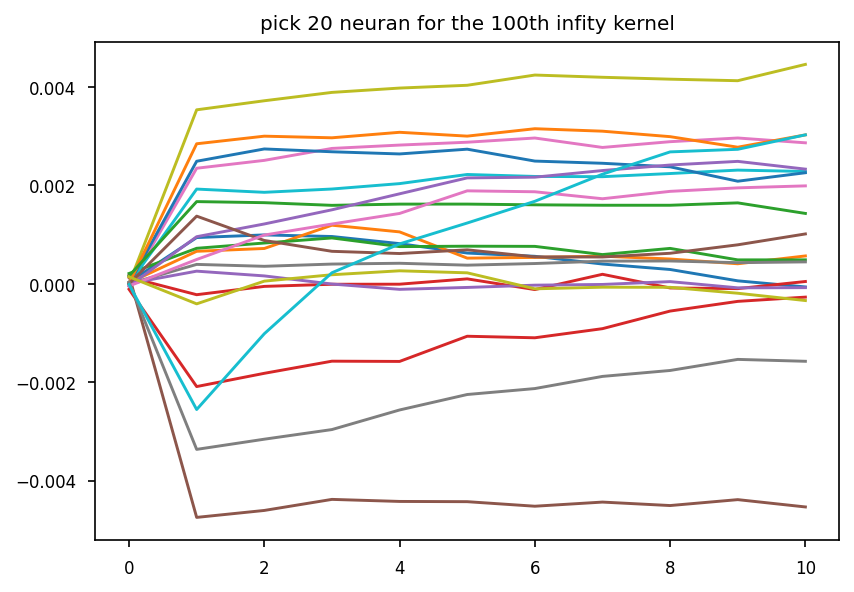

Text(0.5, 1.0, 'change of coefficient of all neurans w.r.t. the 100th infity kernel')

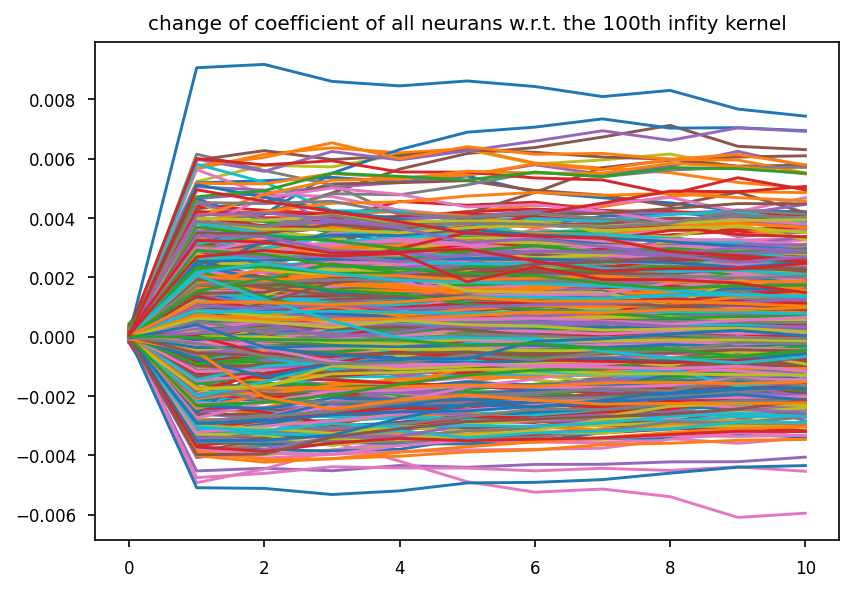

In [ ]:
j=100
coe = coeff_base(Phi, K, j)
rand_pick = 20
sample = random.sample(range(len(coe[0, :])), rand_pick)
for i in range(rand_pick):
  plt.plot(range(epochs+1), coe[:, sample[i]])
plt.title('pick {} neuran for the {}th infity kernel'.format(rand_pick, j))
plt.show()

for nueran in range(len(coe[0, :])):
  plt.plot(range(epochs+1), coe[:, nueran])

plt.title('change of coefficient of all neurans w.r.t. the {}th infity kernel'.format(j))

Now compute the relative distance for testing data and distance between $W$ and $W_{∞}$ ($\frac{\|W-W_{∞}\|_{fro}}{\|W_{∞}\|_{fro}}$)

In [ ]:
epoch_state[num_epochs-1]['state_dict'].keys()

odict_keys(['conv1.0.weight', 'conv1.0.bias', 'conv1.1.weight', 'conv1.1.bias', 'conv1.1.running_mean', 'conv1.1.running_var', 'conv1.1.num_batches_tracked', 'conv2.0.weight', 'conv2.0.bias', 'conv2.1.weight', 'conv2.1.bias', 'conv2.1.running_mean', 'conv2.1.running_var', 'conv2.1.num_batches_tracked', 'conv3.0.weight', 'conv3.0.bias', 'conv3.1.weight', 'conv3.1.bias', 'conv3.1.running_mean', 'conv3.1.running_var', 'conv3.1.num_batches_tracked', 'conv4.0.weight', 'conv4.0.bias', 'conv4.1.weight', 'conv4.1.bias', 'conv4.1.running_mean', 'conv4.1.running_var', 'conv4.1.num_batches_tracked', 'conv5.0.weight', 'conv5.0.bias', 'conv5.1.weight', 'conv5.1.bias', 'conv5.1.running_mean', 'conv5.1.running_var', 'conv5.1.num_batches_tracked', 'classifier.0.weight', 'classifier.0.bias', 'classifier.0.running_mean', 'classifier.0.running_var', 'classifier.0.num_batches_tracked', 'classifier.1.weight'])

Text(0.5, 1.0, 'log scale of relative distance between W')

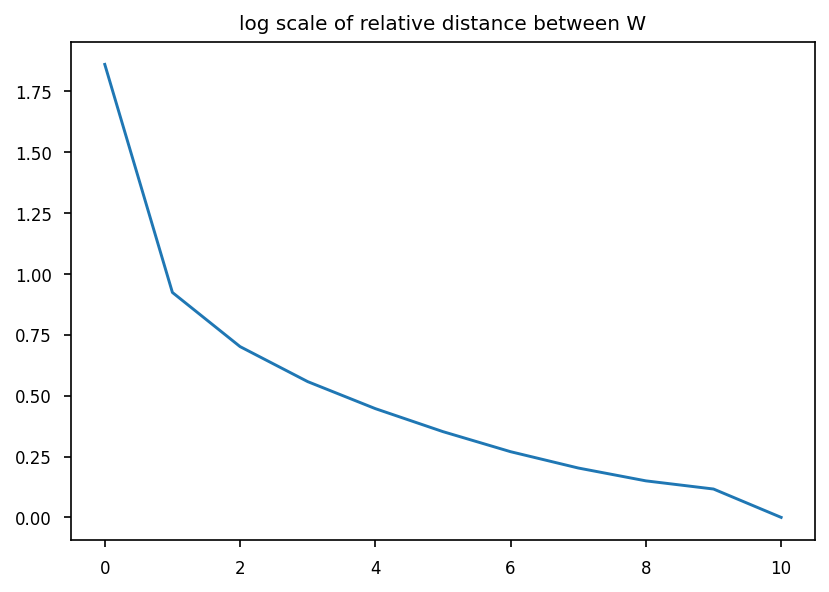

In [ ]:
distance_weight = []
W_infity = epoch_state[num_epochs-1]['state_dict']['classifier.1.weight']
W_infity_norm = torch.norm(W_infity, 'fro')
for epoch in range(num_epochs):
  diff = all_epoch_state[epoch]['state_dict']['classifier.1.weight']- W_infity
  distance_weight.append((torch.norm(diff, 'fro')/W_infity_norm).cpu())

plt.plot(range(num_epochs), distance_weight)
#plt.yscale('log')
plt.title('log scale of relative distance between W')
# with initial weight

Now measure distance between function base.


Conjecture 1: Using all testing data to measure the distance:
$$
dist(\phi, \phi_{∞})=1/N\sum_{i=1}^{N}\|\phi(x_{i})-\phi_{∞}(x_{i})\|_{2}
$$
where $\phi(x):R^{in}\rightarrow R^{L}$.

[tensor(24.1316), tensor(6.6390), tensor(5.5008), tensor(4.5727), tensor(3.7571), tensor(3.3539), tensor(2.7486), tensor(2.1767), tensor(1.7897), tensor(2.2256)]


Text(0.5, 1.0, 'log scale of distance between phi and phi_inf')

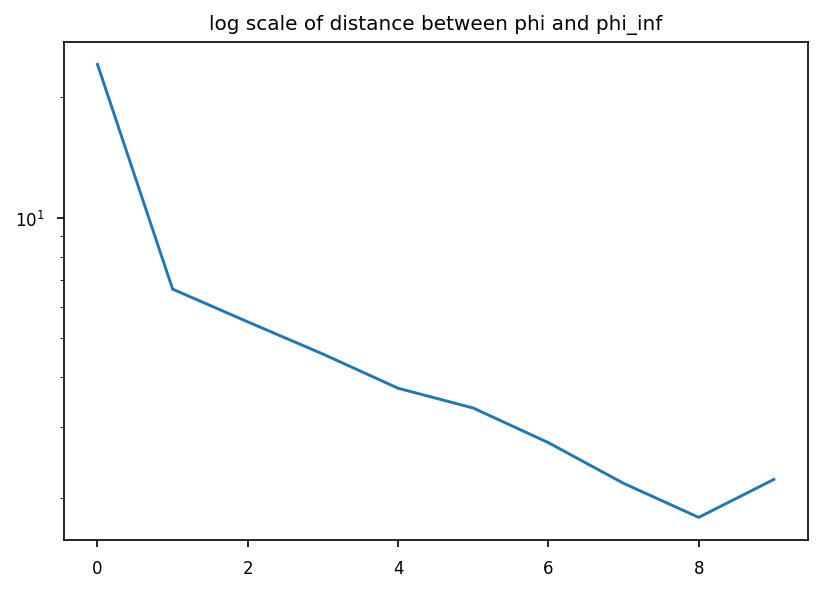

In [ ]:
# define row norm
#Phi = torch.load('Phi_20epochs')
def rnorm(A):
  [m, n] = A.size()
  ave_rnorm = 0
  for i in range(m):
    ave_rnorm += torch.norm(A[i], 'fro')
  ave_rnorm = ave_rnorm/m
  return ave_rnorm

phi_infity = Phi[epochs]
[test_size , neurans] = phi_infity.size()
phi_norm_err = []
phi_i_l1_norm = torch.empty((0,neurans))
phi_i_l2_norm = torch.empty((0,neurans))
phi_i_max_norm = torch.empty((0,neurans))
uni_phi_norm_err = []

for epoch in range(epochs):
  # conjecture 1: phi 2-norm
  norm_err = rnorm(Phi[epoch] - phi_infity) #phi_acc) 
  phi_norm_err.append(norm_err)
  # unite norm err
  uni_phi_norm_err.append(rnorm(F.normalize(Phi[epoch]) - F.normalize(phi_infity)))
  # conjecture 2: phi_{i} L1 norm
  phi_i_l1_norm = torch.vstack((phi_i_l1_norm, (torch.abs(Phi[epoch] - phi_infity)).mean(dim = 0)))
  # conjecture 2: phi_{i} L2 norm
  phi_i_l2_norm = torch.vstack((phi_i_l2_norm, torch.sqrt(((Phi[epoch] - phi_infity)**2).mean(dim = 0))))
  # conjecture 2: phi_{i} max norm
  phi_i_max_norm = torch.vstack((phi_i_max_norm, torch.max(torch.abs(Phi[epoch] - phi_infity), 0)[0]))
print(phi_norm_err)
plt.plot(range(epochs), (phi_norm_err))
plt.yscale('log')
plt.title('log scale of distance between phi and phi_inf')

Another metric: Since the last layer is linear without bias, so the length of the feature map vector $\phi$ is not important. Because we can scale the length and yeild the same prediction. So I think maybe we can use another metric which cares more about angles between $\phi$. Hence I measure the distance for normalized $\phi(x_{i})$.

Text(0.5, 1.0, 'distance between unit phi and phi_inf')

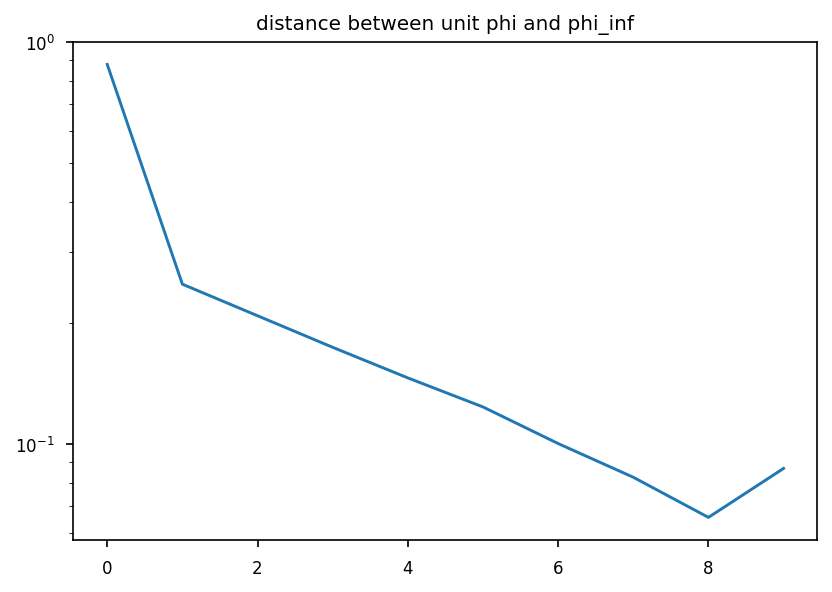

In [ ]:
plt.plot(range(epochs), (uni_phi_norm_err))
plt.yscale('log')
plt.title('distance between unit phi and phi_inf')

Conjecture 2: Consider the functional distance of each argument of $\phi(x), i.e. \phi_{i}(x):R^{in}→R$.

Metric 1: $max$ distance: $dist(\phi_{i}(x),\phi_{i}^{*}(x):=\max_{X\in D}|\phi_{i}(x)-\phi_{i}^{*}(x)|$.

Text(0.5, 1.0, 'max distance')

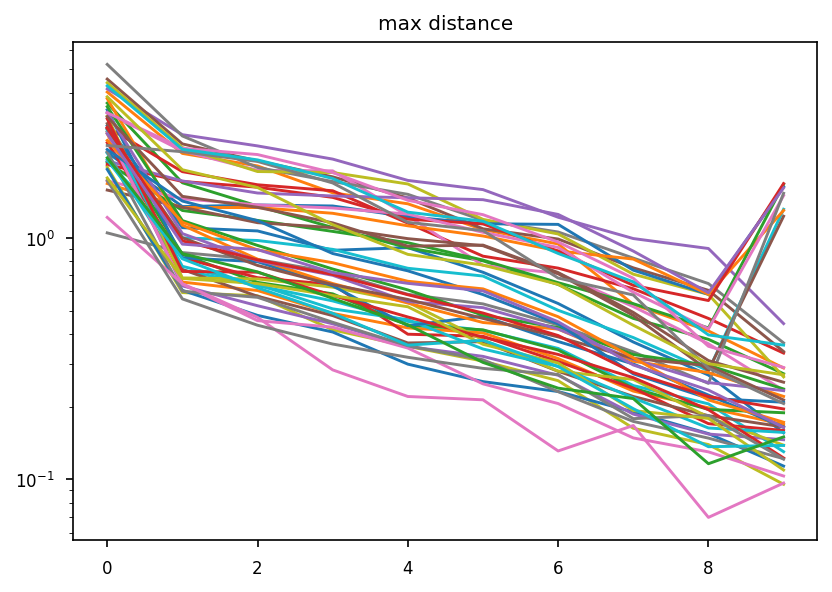

In [ ]:
for epoch in range(50):
  plt.plot(range(epochs), phi_i_max_norm[:, epoch])

plt.yscale('log')
plt.title('max distance')


Metric 2: $L_{1}$ distance: $dist(\phi_{i}(x),\phi_{i}^{*}(x):=E_{X\in D}\left\{|\phi_{i}(x)-\phi_{i}^{*}(x)|\right\}$.

In [ ]:
for epoch in range(epochs):
  plt.plot(range(epochs), phi_i_l1_norm[:, epoch])
plt.yscale('log')
plt.title('L1 distance')

Metric 3: $L_{p}$ distance: $dist(\phi_{i}(x),\phi_{i}^{*}(x):=\sqrt[p]{E_{X\in D}|\left\{\phi_{i}(x)-\phi_{i}^{*}(x)|^{p}\right\}}$.

In [ ]:
for epoch in range(epochs):
  plt.plot(range(epochs), phi_i_l2_norm[:, epoch])

plt.yscale('log')
plt.title('L2 distance')

In [ ]:
a=[2,3,4,5,2]
max(a)

5

The coefficients seems to behave as we expect. But the coefficient for the first maybe 30 kernels are large enough (around 0.1), the rest are very small (around 1e-7). It seems the order we pick orthogonal basis will affect final outcome?